# CS 773 Data Mining and Security

## Course Project - Analyzing Open University Learning Analytics Dataset 

### Problem Statement 

Based on the given data of students enrolled in various courses identify the student who is at-risk so that suitable interventions can be taken to help students succeed. 

***Part-3 : Preprocessing and Feature Engineering***

In this part we will try to extract the features based on the insights and inferences from EDA.

In [96]:
#importing Libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
# Reading Data
student_info = pd.read_csv('../data/studentInfo.csv')
student_assessment = pd.read_csv('../data/studentAssessment.csv')
student_registration = pd.read_csv('../data/studentRegistration.csv')
student_vle = pd.read_csv('../data/studentVle.csv')
assessments = pd.read_csv('../data/assessments.csv')
courses = pd.read_csv('../data/courses.csv')
vle = pd.read_csv('../data/vle.csv')

#check for the data
print('----- Rows -----')
print('Courses     : ',courses.shape[0])
print('Assessments : ',assessments.shape[0])
print('vle(Virtual Learning Environment) : ',vle.shape[0])
print('Student Info         : ',student_info.shape[0])
print('student Assessment   : ',student_assessment.shape[0])
print('student Registration : ',student_registration.shape[0])
print('student Vle          : ',student_vle.shape[0])

----- Rows -----
Courses     :  22
Assessments :  206
vle(Virtual Learning Environment) :  6364
Student Info         :  32593
student Assessment   :  173912
student Registration :  32593
student Vle          :  10655280


In [7]:
# Import required packages
from sklearn import preprocessing
#--- as final_result is a categorical column we can convert that into numeric using label_encoding
labelEncoder = preprocessing.LabelEncoder()
OHencoder= preprocessing.OneHotEncoder()

In [60]:
#Utilities
"""
Calculates sum based on the previous value
"""
def compute_weighted_sum(data, current_val, new_col):
    data[new_col] = data[current_val].cumsum()
    return data


In [101]:
"""
Get mean of the split data
"""
def split_mean(x):
    split_list = x.split('-')
    mean = (float(split_list[0])+float(split_list[1]))/2
    return mean

In [106]:
"""
Preprocessing Student_info
"""

def preprocess_student_info(data):
    data_pre = data.copy()
    data_pre['final_result'] = labelEncoder.fit_transform(data_pre['final_result'])
    #convert categorical columns 
    #----imd_band
    # Remove % first and replace '?' with 0 
    data_pre['imd_band'] =  data_pre['imd_band'].apply(lambda x : x.replace('%',''))
    data_pre['imd_band'] =  data_pre['imd_band'].apply(lambda x : '0' if x == '?' else x)
    #compute mean of the range and add them in seperate column
    data_pre['imd_band_mean'] = data_pre['imd_band'].apply(lambda x : 0 if x == '0' else split_mean(x))
    #----age_band
    # Replace '55<=' with 55 and other ranges with their mean 
    data_pre['age_band_mean'] =  data_pre['age_band'].apply(lambda x : 55 if x == '55<=' else split_mean(x))
    data_pre = data_pre[['code_module','code_presentation','id_student','gender','region','highest_education','num_of_prev_attempts','studied_credits','imd_band','imd_band_mean','age_band','age_band_mean','final_result']]
    return data_pre
        

### Feature Extraction from student_info

***For Calculation purpose we encode the categorical data***

Label Encoding : Only for the Final variable

*In this case*

distinction  - 0

fail  - 1

pass  - 2

withdrawn - 3

One-Hot Encoding

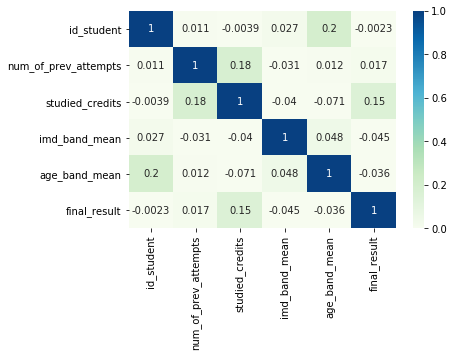

In [107]:
# generating heatmap and mapping correlation matrix -- Using Demographic info -- student_info
#student_info.info() #--- to get info
#student_info.isnull().sum() #--- No NULL Columns
# breaking the data frame into categorical and non categorical value to get the correlation matrix
#as student id is unique we might not require that 
#--- columns num_prev_attempts, studied_credits [['num_of_prev_attempts','studied_credits', 'final_result']]
student_info_numeric = preprocess_student_info(student_info)
#student_info_numeric.corr()
sns.heatmap(student_info_numeric.corr(), annot = True, vmin = 0, cmap = 'GnBu')
plt.show()

 We can see that in predicting final_result, ***studied_credits*** have a very strong impact compared to prevous attmepts
 
 we can also use columns like highest_education, age_band

In [10]:
student_info.info() #--- to get info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
code_module             32593 non-null object
code_presentation       32593 non-null object
id_student              32593 non-null int64
gender                  32593 non-null object
region                  32593 non-null object
highest_education       32593 non-null object
imd_band                32593 non-null object
age_band                32593 non-null object
num_of_prev_attempts    32593 non-null int64
studied_credits         32593 non-null int64
disability              32593 non-null object
final_result            32593 non-null object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [109]:
student_bg = student_info[['highest_education','region','final_result']]
student_info_cat = pd.get_dummies(student_info[['code_module','code_presentation','gender','highest_education','region']])
#student_bg['highest_education'] = labelEncoder.fit_transform(student_bg['highest_education'])
#student_bg['region'] = labelEncoder.fit_transform(student_bg['region'])

#x = OHencoder.fit_transform(student_bg['highest_education']).to_Array()

### Feature extraction from student_assessment

- to get the student assessment pass/fail we know that if scoe is < 40 - fail, >= 40 and <=100 - pass

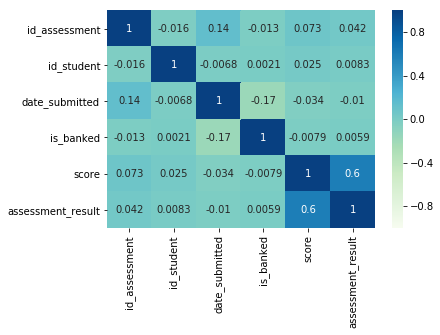

In [65]:
""" # --student_assessment.info()
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
id_assessment     173912 non-null int64
id_student        173912 non-null int64
date_submitted    173912 non-null int64
is_banked         173912 non-null int64
score             173912 non-null object ---- no null values but has '?' for 173 rows replace it with 0 as this may casue problem

Pass - 1
Fail - 0
"""
student_asmt = student_assessment.copy()
student_asmt[(student_asmt['is_banked'] == 1) & (student_asmt['score'] == '?')]
#preprocessing is required replace '?' with 0
student_asmt['score'] = np.where(student_asmt['score'] == '?', '0', student_asmt['score'])
student_asmt['score'] = pd.to_numeric(student_asmt['score'])
student_asmt['assessment_result'] = np.where(student_asmt['score'] >= 40, 1, 0)
#plotting correlation matrix to determine inportant feature for predicting the result 
sns.heatmap(student_asmt.corr(), annot = True, vmin = -1, cmap = 'GnBu')
plt.show()

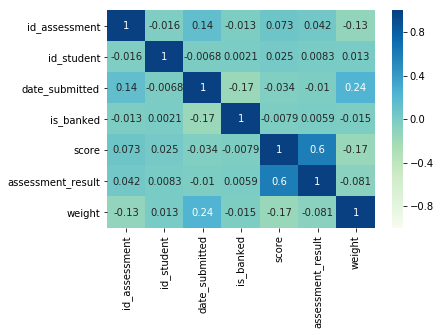

In [66]:
#assesments table 
#assessments.info()
#assessments[assessments['date']=='?']
#assessments[assessments['code_module']=='EEE']
#---- merge tables assessments and student_assessments
student_assessments_all = pd.merge(student_asmt, assessments, how = 'outer', on='id_assessment' )
#plotting correlation matrix to determine inportant feature for predicting the result 
sns.heatmap(student_assessments_all.corr(), annot = True, vmin = -1, cmap = 'GnBu')
plt.show()


In [67]:
#adding some more columns
assessments_stats = assessments.groupby(['code_module','code_presentation']).agg({'weight' : 'sum'})
assessments_stats.reset_index(level=[0,1], inplace=True)
assessments_stats.columns = ['code_module','code_presentation','total_marks']
assessments_stats = pd.merge(assessments, assessments_stats, how='left', on=['code_module','code_presentation'])
assessments_stats['percent_of_total'] = np.divide(assessments_stats['weight'],assessments_stats['total_marks'])*100
#assessments_stats.groupby(['code_module','code_presentation']).size()
assessments_stats = assessments_stats.groupby(['code_module','code_presentation']).apply(compute_weighted_sum, 'percent_of_total', 'weight_in_total')
assessments_stats.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,total_marks,percent_of_total,weight_in_total
0,AAA,2013J,1752,TMA,19,10.0,200.0,5.0,5.0
1,AAA,2013J,1753,TMA,54,20.0,200.0,10.0,15.0
2,AAA,2013J,1754,TMA,117,20.0,200.0,10.0,25.0
3,AAA,2013J,1755,TMA,166,20.0,200.0,10.0,35.0
4,AAA,2013J,1756,TMA,215,30.0,200.0,15.0,50.0


In [69]:
student_assessments_all = pd.merge(student_assessment, assessments_stats, how = 'outer', on='id_assessment' )
student_assessments_all['score'] = np.where(student_assessments_all['score'] == '?', '0', student_assessments_all['score'])
student_assessments_all['score'] = pd.to_numeric(student_assessments_all['score'])
student_assessments_all['assessment_result'] = np.where(student_assessments_all['score'] >= 40, 1, 0)
student_assessments_all['score_weight'] = np.divide(student_assessments_all['score'],100)*student_assessments_all['percent_of_total']
student_assessments_all = student_assessments_all.dropna()
#student_assessments_all.id_student.nunique()
student_assessments_all = student_assessments_all.groupby(['code_module','code_presentation','id_student']).apply(compute_weighted_sum,'score_weight', 'score_in_total')
student_assessments_all = student_assessments_all[['code_module','code_presentation','id_student','id_assessment','assessment_type','date','date_submitted','is_banked',
                                                   'score','weight','percent_of_total','score_weight','weight_in_total','score_in_total','total_marks','assessment_result']]
#student_assessments_all[student_assessments_all['id_student'] == 63400]
student_assessments_all = student_assessments_all.dropna()

In [70]:
student_assessments_all[student_assessments_all['id_student'] == 63400]

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,date_submitted,is_banked,score,weight,percent_of_total,score_weight,weight_in_total,score_in_total,total_marks,assessment_result
13,AAA,2013J,63400.0,1752,TMA,19,19.0,0.0,83.0,10.0,5.0,4.15,5.0,4.15,200.0,1
514,AAA,2013J,63400.0,1753,TMA,54,54.0,0.0,42.0,20.0,10.0,4.20,15.0,8.35,200.0,1
855,AAA,2013J,63400.0,1754,TMA,117,117.0,0.0,78.0,20.0,10.0,7.80,25.0,16.15,200.0,1
1045,AAA,2013J,63400.0,1755,TMA,166,166.0,0.0,76.0,20.0,10.0,7.60,35.0,23.75,200.0,1
1470,AAA,2013J,63400.0,1756,TMA,215,215.0,0.0,79.0,30.0,15.0,11.85,50.0,35.60,200.0,1


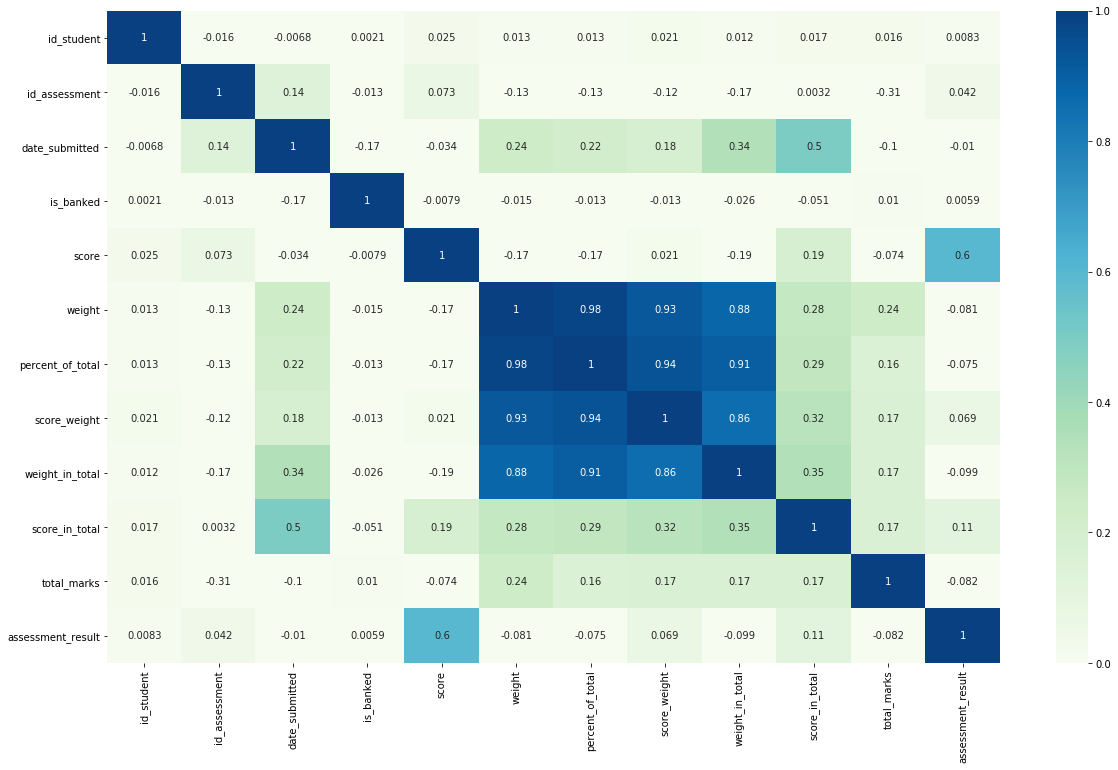

In [71]:
#try to find correlation between final_result and remaining variables
plt.figure(figsize=(20,12))
sns.heatmap(student_assessments_all.corr(), annot = True, vmin = 0, cmap = 'GnBu')
plt.show()

***Inferences***
- we can see that score has a major role in predicting the final result of assessment, the score_in _total comes second so we can use them in features, where as date submitted has least

### Feature Extraction from student_vle

- Based on the insights from Part1, we can create 2 data frames, 1 for having mean of total number of clicks for whole course, 2 for having the distribution of clicks for all the assessments individually. 

- extract the feature of the student, in VLE context we know that the usefulthing is number of clicks, but the clicks vary by many activity_types mapped with id_site in vle_table, based on the inference from EDA we can extract the information by taking  ***assessment_deadline*** and comparing it with ***date*** column in student_vle to calculate the number of clicks before that assessment, in this way we can use the data to predict the final_result.


***Creating a dataframe by merging student_info with student_clicks for particular course***

In [123]:
#student_vle.info()
student_clicks = student_vle.groupby(['id_student', 'code_module', 'code_presentation']).agg({'sum_click':['mean','sum']})
student_clicks.reset_index(level=[0,1,2], inplace=True)
student_clicks.columns = ['id_student', 'code_module', 'code_presentation', 'mean_clicks', 'sum_clicks']
#student_clicks
# merging student_clicks with student info
student_course_info = pd.merge(student_info,student_clicks, how='left', left_on=['id_student', 'code_module', 'code_presentation'],right_on=['id_student', 'code_module', 'code_presentation'])
student_course_info.reset_index(level=[0], inplace=True)
student_course_info.head()

,index,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,mean_clicks,sum_clicks
0,0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,4.765306,934.0
1,1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,3.337209,1435.0
2,2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,3.697368,281.0
3,3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,3.254902,2158.0
4,4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,2.937500,1034.0


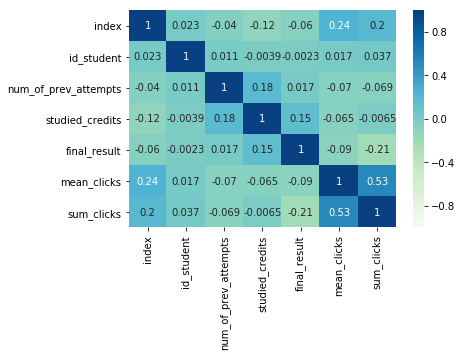

In [59]:
student_course_info['final_result'] = labelEncoder.fit_transform(student_course_info['final_result'])
sns.heatmap(student_course_info.corr(), annot = True, vmin = -1, cmap = 'GnBu')
plt.show()

***by seeing the above heatmap of correlation we can say that number of clicks might not be an important feature at all as the show less correlation with the final_result***

In [121]:
#merge
def getAssessmentdetails(data1, data2,new_col):
    #data2[new_col] = np.where(data2['date'] <= (data1['date']),data1['id_assessment'],'?')
    #print(np.array(data2['date']))
    return data1 
#assessments_group_by = assessments.groupby(['code_module','code_presentation'])
#student_vle_group_by = student_vle.groupby(['code_module','code_presentation']).apply()

In [122]:
assessments_group_by = assessments.copy()
assessments_group_by['date'] = np.where(assessments_group_by['date'] == '?', '0', assessments_group_by['date'])
assessments_group_by['date'] = pd.to_numeric(assessments_group_by['date'])
assessments_group_by = assessments_group_by.groupby(['code_module','code_presentation'])
student_vle_group_by = student_vle.groupby(['code_module','code_presentation']).apply(getAssessmentdetails,assessments_group_by,'id_assessment')
#getAssessmentdetails(assessments_group_by, student_vle_group_by, 'id_assessment')
#student_vle_group_by

In [73]:
student_vle[student_vle['id_student'] == 63400]['sum_click']

99        22
100        1
101        1
102        5
103        1
104        1
105        8
106        1
107        6
3181       7
3182       1
3921       2
5303       6
5304       1
5305      12
5306       1
5307       9
5308       7
5309       3
5310       1
6229       7
6230      12
6231      10
6232       9
6233       1
6234      12
6235       1
6236      15
6237      12
6238       1
          ..
178067     2
178068     2
178879     1
178880     3
178881     1
178882     2
178883     1
179640     1
179641     1
180043     1
180050     1
180051     2
180052     2
180482     2
180566     1
180678     4
180679     3
180680     4
180724     2
180725     2
180726     2
180839     1
180840     1
180841     1
180894     1
180895     1
180896     1
180935     1
180936     1
180937     1
Name: sum_click, Length: 760, dtype: int64